# Example 2: Boundary conditions
Demonstration of different types of VDERM boundary conditions:

1. Free
2. Fixed (no flux)
3. Mixed (symmetrical)
4. Mixed (asymmetrical/custom)

In [14]:
import pyVDERM as vd
import numpy as np

### Import a mesh file and create a point cloud

In [15]:
points, norms = vd.create_pcd('cube.stl',n_pts=10_000)

# Free boundary conditions
Free boundary conditions are the default deformation setting. This means that when creating the underlying grid, the object will be placed in the center of a 'sea' with a length, width, and height of 2x the object. No flux boundaries are enforced at the edges of the sea, but the object may deform freely within the sea. 

The size of the sea can be edited with the padding parameter, which takes a tuple of ratios (ratio_x,ratio_y,ratio_z). The dimensions of the sea along each axis will be the ratio along that axis multiplied by the object's length along that axis. Padding ratios must be >=1.

In [16]:
grid_params = vd.make_initial_grid(points,max_points=32_000)
vd.print_grid_info(grid_params)

GRID INFORMATION

Grid dimensions: 32 × 32 × 32 = 32,768 points
Grid spacing (h): 0.355476

Grid size:   [11.0198, 11.0198, 11.0198]
Object size: [5.5099, 5.5099, 5.5099]
Ratio:       [2.00x, 2.00x, 2.00x]

Grid bounds:
  x: [-5.5099, 5.5099]
  y: [-5.5099, 5.5099]
  z: [-5.5099, 5.5099]

Object bounds:
  x: [-2.7549, 2.7549]
  y: [-2.7549, 2.7549]
  z: [-2.7549, 2.7549]

Object margins (distance from grid boundary):
  x: min=2.7549, max=2.7549
  y: min=2.7549, max=2.7549
  z: min=2.7549, max=2.7549

Verification for padding ratios:
  x: 2.000x
  y: 2.000x
  z: 2.000x


### Assign densities
For this example, the cube will be divided into 8 equal, discontinuous regions.

In [17]:
rho_0 = np.zeros(grid_params['shape'])
def density_from_index(I,J,K):
    sea_density = np.mean([1,3,5,7,9,11,13,15])
    if I<10 or J<10 or K<10 or I>22 or J>22 or K>22:
        return sea_density
    elif I<16 and J<16 and K<16:
        return 1
    elif I>=16 and J<16 and K<16:
        return 3
    elif I<16 and J>=16 and K<16:
        return 5
    elif I>=16 and J>=16 and K<16:
        return 7
    elif I<16 and J<16 and K>=16:
        return 9
    elif I>=16 and J<16 and K>=16:
        return 11
    elif I<16 and J>=16 and K>=16:
        return 13
    elif I>=16 and J>=16 and K>=16:
        return 15
    else:
        raise IndexError("Index not in assigned region")
    
for i in range(rho_0.shape[0]):
    for j in range(rho_0.shape[1]):
        for k in range(rho_0.shape[2]):
            rho_0[i,j,k] = density_from_index(i,j,k)

### Deform and plot results

In [18]:
vdgrid = vd.VDERMGrid(shape=grid_params['shape'],h=grid_params['h'],min_bounds=grid_params['min_bounds'])
vdgrid.set_density(rho_0)
deformed_grid = vd.run_VDERM(vdgrid, n_max=1000)

Converged:  36%|███▌      | 356/1000 [01:31<02:44,  3.91it/s, ε=9.991e-03, target=1.000e-02]


Converged at iteration 356


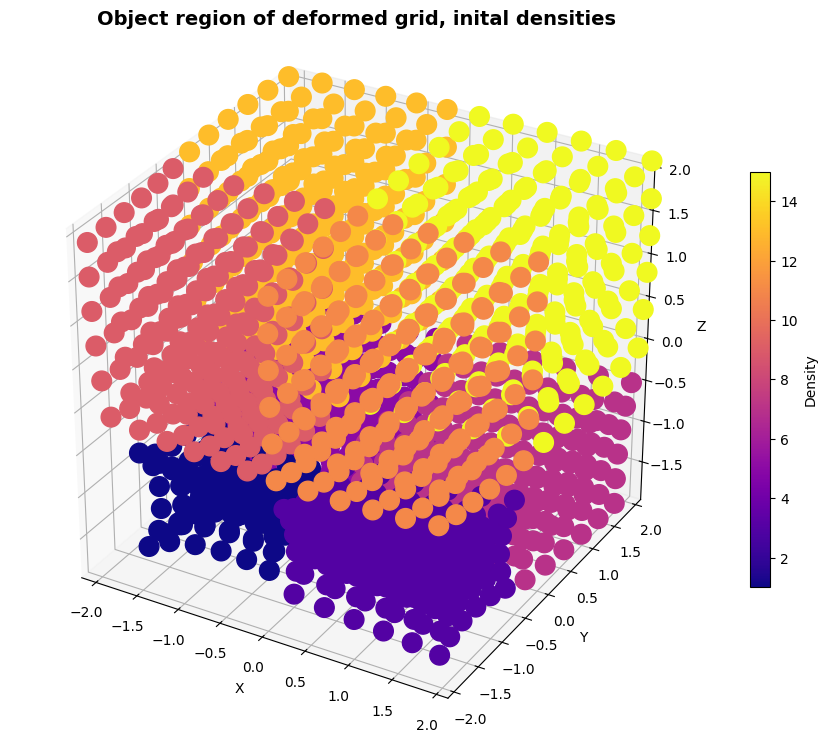

In [19]:
positions_3d = vdgrid.positions.reshape(vdgrid.L, vdgrid.M, vdgrid.N, 3)
object_densities = rho_0[10:22,10:22,10:22].ravel()
object_positions = positions_3d[10:22,10:22,10:22].reshape(object_densities.shape[0],3)
fig = vd.plot_pcd(object_positions,object_densities,view='3d',point_size=200,alpha=1,title='Object region of deformed grid, inital densities')

# Fixed boundary conditions 
The underlying vderm grid enforces no flux boundary conditions by default for the edges of the 'sea'- there will be no density flux through the outer planes, so the boundaries are held in place. By making the padding ratio 1, we eliminate hte sea and create fixed boundaries for the object 

In [20]:
grid_params = vd.make_initial_grid(points,max_points=32_000,padding=(1,1,1))
vd.print_grid_info(grid_params)

GRID INFORMATION

Grid dimensions: 32 × 32 × 32 = 32,768 points
Grid spacing (h): 0.177738

Grid size:   [5.5099, 5.5099, 5.5099]
Object size: [5.5099, 5.5099, 5.5099]
Ratio:       [1.00x, 1.00x, 1.00x]

Grid bounds:
  x: [-2.7549, 2.7549]
  y: [-2.7549, 2.7549]
  z: [-2.7549, 2.7549]

Object bounds:
  x: [-2.7549, 2.7549]
  y: [-2.7549, 2.7549]
  z: [-2.7549, 2.7549]

Object margins (distance from grid boundary):
  x: min=0.0000, max=0.0000
  y: min=0.0000, max=0.0000
  z: min=0.0000, max=0.0000

Verification for padding ratios:
  x: 1.000x
  y: 1.000x
  z: 1.000x


### Density assignment
The density assignment is the same, but no sea is needed in this case

In [21]:
rho_0 = np.zeros(grid_params['shape'])
def density_from_index(I,J,K):
    if I<16 and J<16 and K<16:
        return 1
    elif I>=16 and J<16 and K<16:
        return 3
    elif I<16 and J>=16 and K<16:
        return 5
    elif I>=16 and J>=16 and K<16:
        return 7
    elif I<16 and J<16 and K>=16:
        return 9
    elif I>=16 and J<16 and K>=16:
        return 11
    elif I<16 and J>=16 and K>=16:
        return 13
    elif I>=16 and J>=16 and K>=16:
        return 15
    else:
        raise IndexError("Index not in assigned region")
    
for i in range(rho_0.shape[0]):
    for j in range(rho_0.shape[1]):
        for k in range(rho_0.shape[2]):
            rho_0[i,j,k] = density_from_index(i,j,k)

In [22]:
vdgrid = vd.VDERMGrid(shape=grid_params['shape'],h=grid_params['h'],min_bounds=grid_params['min_bounds'])
vdgrid.set_density(rho_0)
deformed_grid = vd.run_VDERM(vdgrid, n_max=1000)

Deforming: 100%|██████████| 1000/1000 [04:35<00:00,  3.64it/s, ε=3.425e-02, target=1.000e-02]


The object now remains flush with the outer planes. Points on a boundary plane are allowed to slide along that plane to equalize densities

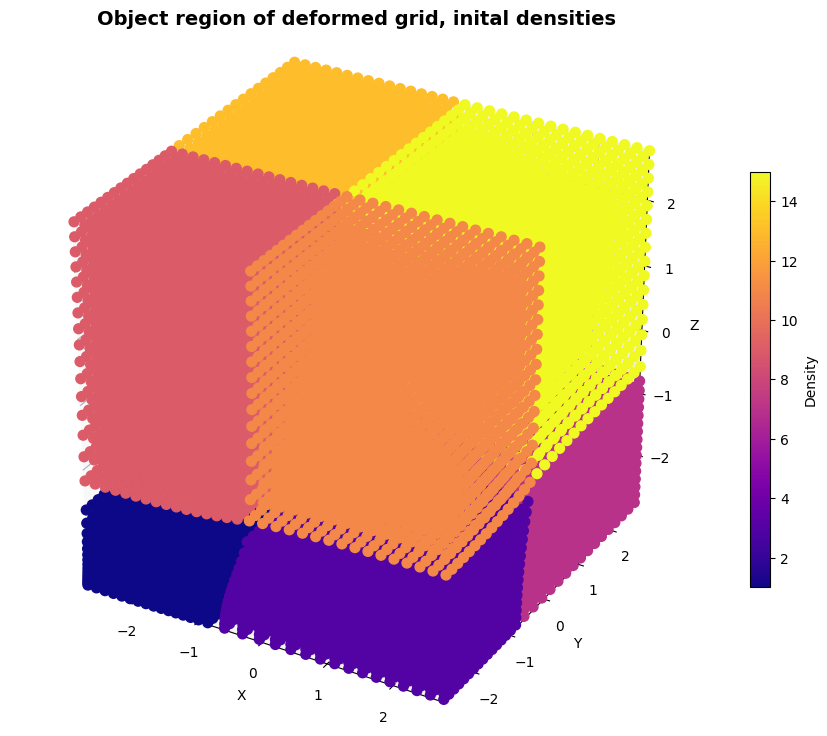

In [23]:
positions_3d = vdgrid.positions.reshape(vdgrid.L, vdgrid.M, vdgrid.N, 3)
object_densities = rho_0.ravel()
object_positions = positions_3d.reshape(object_densities.shape[0],3)
fig = vd.plot_pcd(object_positions,object_densities,view='3d',point_size=50,alpha=1,title='Object region of deformed grid, inital densities')

# Mixed boundary conditions (symmetrical)
By placing the object in a grid such that only some faces of the bounding box are flush with the object, the deformation can be free along some boundaries, and fixed along others. 

The simplest way to create mixed boundary conditions is to set the padding in make_initial_grid to be L',M',N, where L'>L, and M'>M. Then the top and bottom planes will be fixed, while the sides can deform freely. 

In [24]:
grid_params = vd.make_initial_grid(points,max_points=31_000,padding=(2,2,1))
vd.print_grid_info(grid_params)

GRID INFORMATION

Grid dimensions: 40 × 40 × 21 = 33,600 points
Grid spacing (h): 0.282558

Grid size:   [11.0198, 11.0198, 5.6512]
Object size: [5.5099, 5.5099, 5.5099]
Ratio:       [2.00x, 2.00x, 1.03x]

Grid bounds:
  x: [-5.5099, 5.5099]
  y: [-5.5099, 5.5099]
  z: [-2.8256, 2.8256]

Object bounds:
  x: [-2.7549, 2.7549]
  y: [-2.7549, 2.7549]
  z: [-2.7549, 2.7549]

Object margins (distance from grid boundary):
  x: min=2.7549, max=2.7549
  y: min=2.7549, max=2.7549
  z: min=0.0706, max=0.0706

Verification for padding ratios:
  x: 2.000x
  y: 2.000x
  z: 1.026x


In [25]:
rho_0 = np.zeros(grid_params['shape'])
def density_from_index(I,J,K):
    sea_density = np.mean([1,3,5,7,9,11,13,15])
    if I<10 or J<10 or I>30 or J>30:
        return sea_density
    elif I<20 and J<20 and K<11:
        return 1
    elif I>=20 and J<20 and K<11:
        return 3
    elif I<20 and J>=20 and K<11:
        return 5
    elif I>=20 and J>=20 and K<11:
        return 7
    elif I<20 and J<20 and K>=11:
        return 9
    elif I>=20 and J<20 and K>=11:
        return 11
    elif I<20 and J>=20 and K>=11:
        return 13
    elif I>=20 and J>=20 and K>=11:
        return 15
    else:
        raise IndexError("Index not in assigned region")
    
for i in range(rho_0.shape[0]):
    for j in range(rho_0.shape[1]):
        for k in range(rho_0.shape[2]):
            rho_0[i,j,k] = density_from_index(i,j,k)

In [26]:
vdgrid = vd.VDERMGrid(shape=grid_params['shape'],h=grid_params['h'],min_bounds=grid_params['min_bounds'])
vdgrid.set_density(rho_0)
deformed_grid = vd.run_VDERM(vdgrid, n_max=1000)

Converged:  99%|█████████▊| 987/1000 [04:26<00:03,  3.70it/s, ε=9.993e-03, target=1.000e-02]


Converged at iteration 987


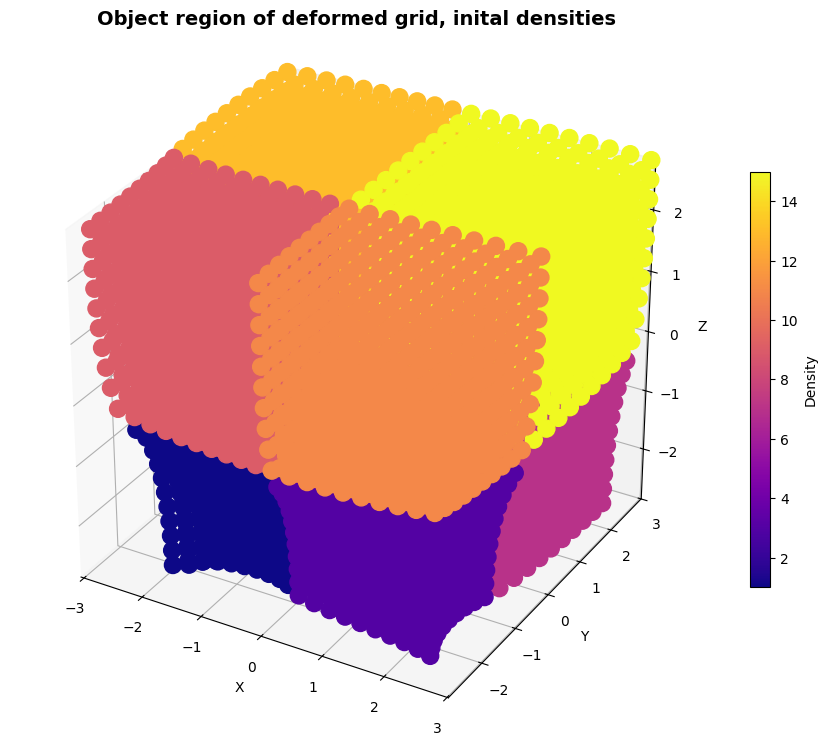

In [27]:
positions_3d = vdgrid.positions.reshape(vdgrid.L, vdgrid.M, vdgrid.N, 3)
object_densities = rho_0[10:30,10:30,:].ravel()
object_positions = positions_3d[10:30,10:30,:].reshape(object_densities.shape[0],3)
fig = vd.plot_pcd(object_positions,object_densities,view='3d',point_size=150,alpha=1,title='Object region of deformed grid, inital densities')

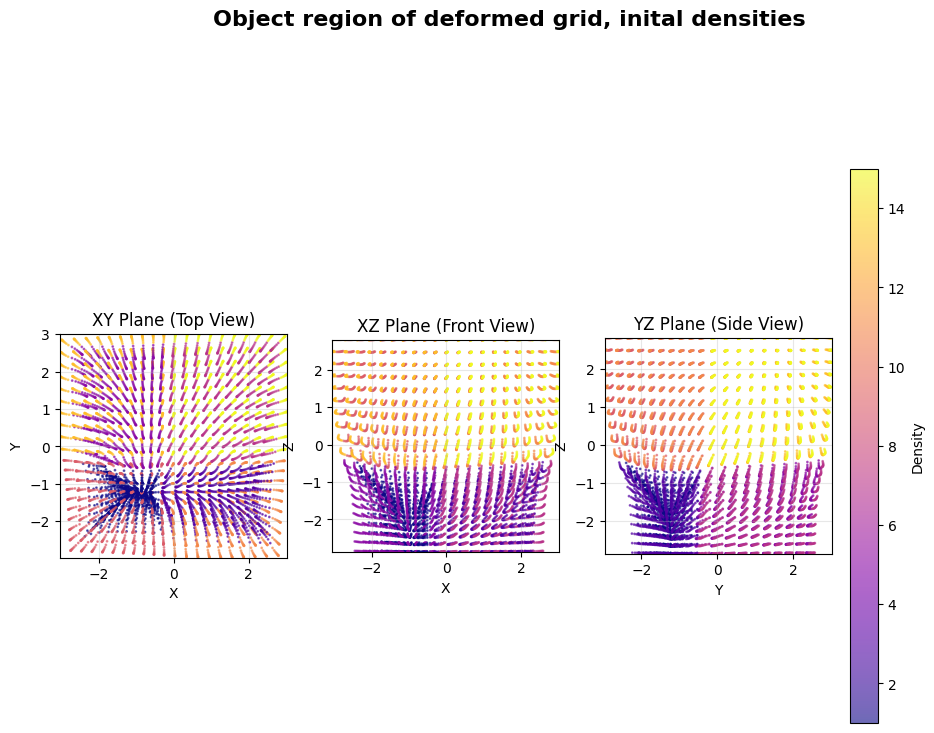

In [28]:
fig = vd.plot_pcd(object_positions,object_densities,view='2d',title='Object region of deformed grid, inital densities')

# Custom mixed boundary conditions (asymmetrical)
If the faces where fixed boundary conditions are needed are not parallel, a custom underlying grid must be created. In this example we will demonstrate 3 deformations, with different numbers of fixed planes

In [29]:
# Find the boundaries of the object
obj_min = points.min(axis=0)
obj_max = points.max(axis=0)
obj_lengths = obj_max - obj_min

# ============================================================
# Option 1: 3 fixed planes (top, right, back)
# Object flush against X_max, Y_max, Z_max
# Padding only on left (X_min), front (Y_min), bottom (Z_min)
# ============================================================
box_dims_3 = obj_lengths * 1.5
box_minimums_3 = obj_max - box_dims_3


print(f"3 fixed planes:")
print(f"  Box dimensions: {box_dims_3}")
print(f"  Box minimums: {box_minimums_3}")
print(f"  Box maximums: {box_minimums_3 + box_dims_3}")
print(f"  Object maximums: {obj_max} (should match box max)")


# ============================================================
# Option 2: 1 fixed plane (e.g., only right side: X_max fixed)
# Object flush against X_max only
# Padding on all other sides
# ============================================================
box_dims_1 = np.array([
    obj_lengths[0] * 1.5,  # X: 0.5x padding on left only
    obj_lengths[1] * 2.0,  # Y: 0.5x padding on each side (centered)
    obj_lengths[2] * 2.0   # Z: 0.5x padding on each side (centered)
])

box_minimums_1 = np.array([
    obj_max[0] - box_dims_1[0],           # X: flush right
    obj_min[1] - obj_lengths[1] * 0.5,  # Y: centered (0.5x padding each side)
    obj_min[2] - obj_lengths[2] * 0.5   # Z: centered (0.5x padding each side)
])

# BUG FIX: Your version had obj_max[1]*1.5 which doesn't make sense
# Should be obj_min - padding or obj_max - total_box_size

print(f"\n1 fixed plane (X_max):")
print(f"  Box dimensions: {box_dims_1}")
print(f"  Box minimums: {box_minimums_1}")
print(f"  Box maximums: {box_minimums_1 + box_dims_1}")
print(f"  Object X_max: {obj_max[0]} (should match box X_max)")


# ============================================================
# Option 3: 2 fixed planes (e.g., right and back: X_max, Y_max fixed)
# Object flush against X_max and Y_max
# Padding on other sides
# ============================================================
box_dims_2 = np.array([
    obj_lengths[0] * 1.5,  # X: 0.5x padding on left only
    obj_lengths[1] * 1.5,  # Y: 0.5x padding on front only
    obj_lengths[2] * 2.0   # Z: 0.5x padding each side (centered)
])

box_minimums_2 = np.array([
    obj_max[0] - box_dims_2[0],           # X: flush right
    obj_max[1] - box_dims_2[1],           # Y: flush back
    obj_min[2] - obj_lengths[2] * 0.5   # Z: centered
])

print(f"\n2 fixed planes (X_max, Y_max):")
print(f"  Box dimensions: {box_dims_2}")
print(f"  Box minimums: {box_minimums_2}")
print(f"  Box maximums: {box_minimums_2 + box_dims_2}")
print(f"  Object X_max: {obj_max[0]}, Y_max: {obj_max[1]}")
print(f"  (should match box X_max, Y_max)")

3 fixed planes:
  Box dimensions: [8.26482582 8.26482582 8.26482582]
  Box minimums: [-5.50988388 -5.50988388 -5.50988388]
  Box maximums: [2.75494194 2.75494194 2.75494194]
  Object maximums: [2.75494194 2.75494194 2.75494194] (should match box max)

1 fixed plane (X_max):
  Box dimensions: [ 8.26482582 11.01976776 11.01976776]
  Box minimums: [-5.50988388 -5.50988388 -5.50988388]
  Box maximums: [2.75494194 5.50988388 5.50988388]
  Object X_max: 2.754941940307617 (should match box X_max)

2 fixed planes (X_max, Y_max):
  Box dimensions: [ 8.26482582  8.26482582 11.01976776]
  Box minimums: [-5.50988388 -5.50988388 -5.50988388]
  Box maximums: [2.75494194 2.75494194 5.50988388]
  Object X_max: 2.754941940307617, Y_max: 2.754941940307617
  (should match box X_max, Y_max)


### Compute box dimensions
In the case of custom grids, pyVDERM has a helper function to compute the shape and spacing of the grid. These parameters can then be passed into the VDERMGrid class and the deformation can proceed as usual

In [30]:
shape_3, h_3 = vd.compute_grid_dimensions(box_dims_3)
shape_2, h_2 = vd.compute_grid_dimensions(box_dims_2)
shape_1, h_1 = vd.compute_grid_dimensions(box_dims_1)


In [31]:
vdgrid1 = vd.VDERMGrid(shape_1,h_1,box_minimums_1)
vdgrid2 = vd.VDERMGrid(shape_2,h_2,box_minimums_2)
vdgrid3 = vd.VDERMGrid(shape_3,h_3,box_minimums_3)

In [32]:
print(shape_1)
print(shape_2)
print(shape_3)

(np.int64(26), 34, 34)
(np.int64(29), 29, 38)
(np.int64(32), 32, 32)


### Assign densities
the regions will be the same as in previous experiments, but the assignments are different because of the different positioning of the object

In [33]:
# 3 fixed faces: X_max, Y_max, Z_max all flush
# Grid shape: (32, 32, 32)
# Object region pushed against the max boundaries

L, M, N = 32, 32, 32
rho_0_3 = np.zeros((L, M, N))

def density_3(i, j, k):
    """
    3 fixed faces - object flush against X_max, Y_max, Z_max.
    Sea region on min sides (low i, j, k).
    """
    sea_density = np.mean([1, 3, 5, 7, 9, 11, 13, 15])
    
    # Sea region: low indices (near min boundaries)
    if i < 10 or j < 10 or k < 10:
        return sea_density
    
    # Object region: 8 blocks in 2×2×2 arrangement
    # Blocks positioned in higher index region (near max boundaries)
    elif 10 <= i < 21 and 10 <= j < 21 and 10 <= k < 21:
        return 1
    elif 21 <= i and 10 <= j < 21 and 10 <= k < 21:
        return 3
    elif 10 <= i < 21 and 21 <= j and 10 <= k < 21:
        return 5
    elif 21 <= i and 21 <= j and 10 <= k < 21:
        return 7
    elif 10 <= i < 21 and 10 <= j < 21 and 21 <= k:
        return 9
    elif 21 <= i and 10 <= j < 21 and 21 <= k:
        return 11
    elif 10 <= i < 21 and 21 <= j and 21 <= k:
        return 13
    elif 21 <= i and 21 <= j and 21 <= k:
        return 15
    else:
        return sea_density

for i in range(L):
    for j in range(M):
        for k in range(N):
            rho_0_3[i, j, k] = density_3(i, j, k)

vdgrid3.set_density(rho_0_3)

In [34]:
# 1 fixed face: X_max flush, Y and Z centered
# Grid shape: (26, 34, 34)
# Object centered in Y and Z, pushed against X_max

L, M, N = 26, 34, 34
rho_0_1 = np.zeros((L, M, N))

def density_1(i, j, k):
    """
    1 fixed face - object flush against X_max only.
    Sea region on X_min side and surrounding Y, Z.
    """
    sea_density = np.mean([1, 3, 5, 7, 9, 11, 13, 15])
    
    # Sea region: low i (X_min side) or edges in j, k
    if i < 8 or j < 7 or j >= 27 or k < 7 or k >= 27:
        return sea_density
    
    # Object region: 8 blocks in 2×2×2 arrangement
    # Positioned in higher i region (near X_max), centered in j, k
    elif 8 <= i < 17 and 7 <= j < 17 and 7 <= k < 17:
        return 1
    elif 17 <= i and 7 <= j < 17 and 7 <= k < 17:
        return 3
    elif 8 <= i < 17 and 17 <= j < 27 and 7 <= k < 17:
        return 5
    elif 17 <= i and 17 <= j < 27 and 7 <= k < 17:
        return 7
    elif 8 <= i < 17 and 7 <= j < 17 and 17 <= k < 27:
        return 9
    elif 17 <= i and 7 <= j < 17 and 17 <= k < 27:
        return 11
    elif 8 <= i < 17 and 17 <= j < 27 and 17 <= k < 27:
        return 13
    elif 17 <= i and 17 <= j < 27 and 17 <= k < 27:
        return 15
    else:
        return sea_density

for i in range(L):
    for j in range(M):
        for k in range(N):
            rho_0_1[i, j, k] = density_1(i, j, k)

vdgrid1.set_density(rho_0_1)

In [35]:
# 2 fixed faces: X_max and Y_max flush, Z centered
# Grid shape: (29, 29, 38)
# Object pushed against X_max and Y_max, centered in Z

L, M, N = 29, 29, 38
rho_0_2 = np.zeros((L, M, N))

def density_2(i, j, k):
    """
    2 fixed faces - object flush against X_max and Y_max.
    Sea region on X_min, Y_min sides and surrounding Z.
    """
    sea_density = np.mean([1, 3, 5, 7, 9, 11, 13, 15])
    
    # Sea region: low i (X_min), low j (Y_min), or Z edges
    if i < 9 or j < 9 or k < 9 or k >= 29:
        return sea_density
    
    # Object region: 8 blocks in 2×2×2 arrangement
    # Positioned in higher i, j region (near X_max, Y_max), centered in k
    elif 9 <= i < 19 and 9 <= j < 19 and 9 <= k < 19:
        return 1
    elif 19 <= i and 9 <= j < 19 and 9 <= k < 19:
        return 3
    elif 9 <= i < 19 and 19 <= j and 9 <= k < 19:
        return 5
    elif 19 <= i and 19 <= j and 9 <= k < 19:
        return 7
    elif 9 <= i < 19 and 9 <= j < 19 and 19 <= k < 29:
        return 9
    elif 19 <= i and 9 <= j < 19 and 19 <= k < 29:
        return 11
    elif 9 <= i < 19 and 19 <= j and 19 <= k < 29:
        return 13
    elif 19 <= i and 19 <= j and 19 <= k < 29:
        return 15
    else:
        return sea_density

for i in range(L):
    for j in range(M):
        for k in range(N):
            rho_0_2[i, j, k] = density_2(i, j, k)

vdgrid2.set_density(rho_0_2)

### Run deformation

In [36]:
deformed_grid1 = vd.run_VDERM(vdgrid1, n_max=1000)
deformed_grid2 = vd.run_VDERM(vdgrid2, n_max=1000)
deformed_grid3 = vd.run_VDERM(vdgrid3, n_max=1000)

Converged:  68%|██████▊   | 681/1000 [02:35<01:12,  4.37it/s, ε=9.995e-03, target=1.000e-02]



Converged at iteration 681


Converged:  79%|███████▉  | 789/1000 [03:07<00:50,  4.21it/s, ε=9.990e-03, target=1.000e-02]



Converged at iteration 789


Deforming: 100%|██████████| 1000/1000 [04:15<00:00,  3.92it/s, ε=1.260e-02, target=1.000e-02]


### Plot results
Note that the fixed boundaries are not truly 'fixed'. Under enough stress, they will deform slightly. This is because the no flux boundary is enforced by a 'ghost node', a node with the same density as the bounding node, one step outside of the box. Numerically, we simply tell the bounding point to refer to its own density when checking its outer neighbor's density. However, there may still be some density propagation outwards from the inner neighbor. This is rarely an observable phenomenon when looking at a deformed object, and in these cases we observe maximum displacements of 0.5% of the length of the object perpendicular to the fixed boundary plane

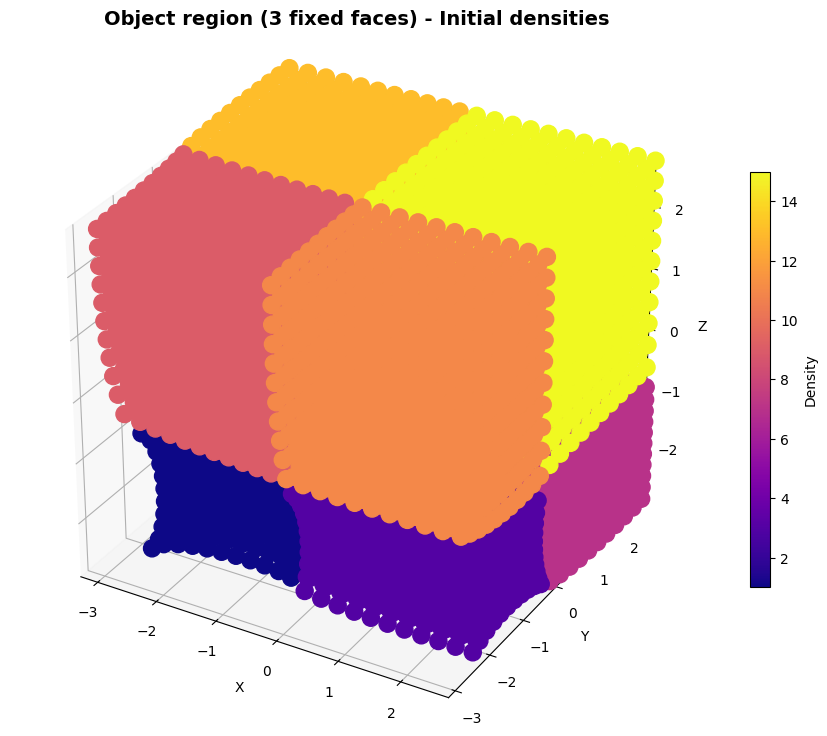

In [37]:
positions_3d_3 = vdgrid3.positions.reshape(vdgrid3.L, vdgrid3.M, vdgrid3.N, 3)

object_densities_3 = rho_0_3[10:32, 10:32, 10:32].ravel()
object_positions_3 = positions_3d_3[10:32, 10:32, 10:32].reshape(object_densities_3.shape[0], 3)

fig = vd.plot_pcd(object_positions_3, object_densities_3,view='3d', point_size=150, alpha=1,title='Object region (3 fixed faces) - Initial densities')

The apparent deformation of the top plane of the object downwards is actually a optical illusion caused by the vertical plane deforming inwards- which can be verified with the 2D view

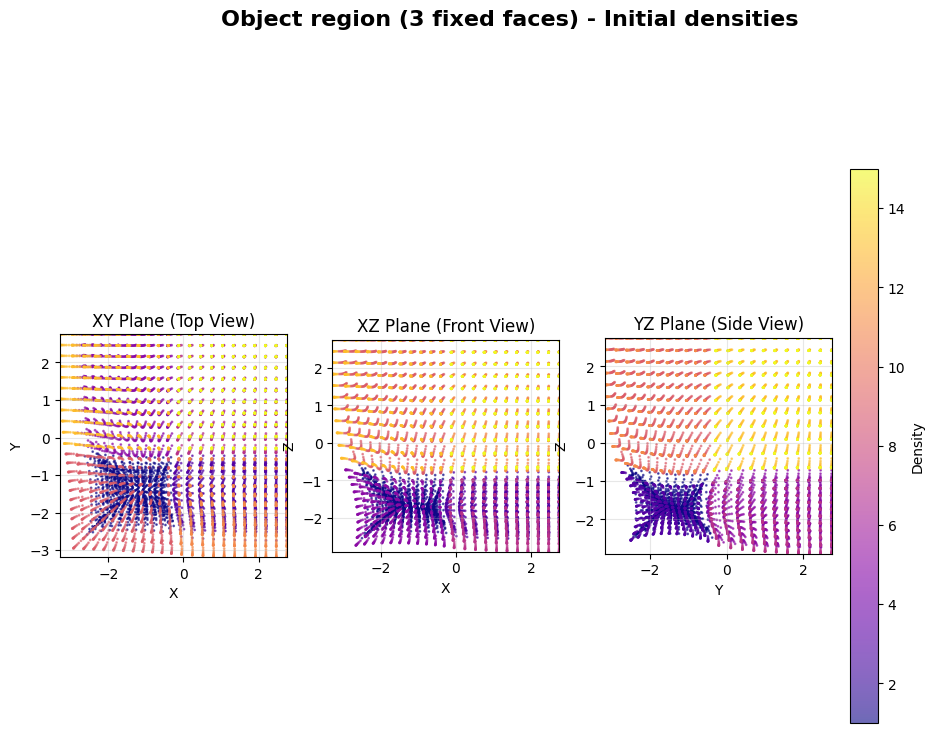

In [38]:
# as expected, the top plane is not vertically deformed (middle panel) but the points 
# slide inwards towards x=0,y=0 slightly in -x, -y region, which is not a fixed boundary region
positions_3d_3 = vdgrid3.positions.reshape(vdgrid3.L, vdgrid3.M, vdgrid3.N, 3)

object_densities_3 = rho_0_3[10:32, 10:32, 10:32].ravel()
object_positions_3 = positions_3d_3[10:32, 10:32, 10:32].reshape(object_densities_3.shape[0], 3)
fig = vd.plot_pcd(object_positions_3, object_densities_3,view='2d',title='Object region (3 fixed faces) - Initial densities')

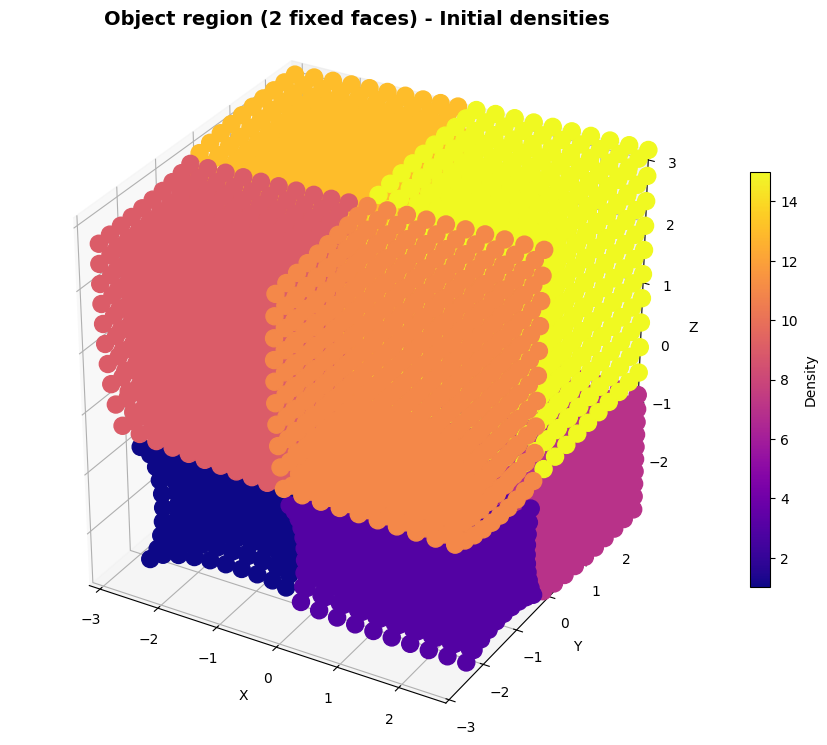

In [39]:
positions_3d_2 = vdgrid2.positions.reshape(vdgrid2.L, vdgrid2.M, vdgrid2.N, 3)

object_densities_2 = rho_0_2[9:29, 9:29, 9:29].ravel()
object_positions_2 = positions_3d_2[9:29, 9:29, 9:29].reshape(object_densities_2.shape[0], 3)

fig = vd.plot_pcd(object_positions_2, object_densities_2,view='3d', point_size=150, alpha=1,title='Object region (2 fixed faces) - Initial densities')

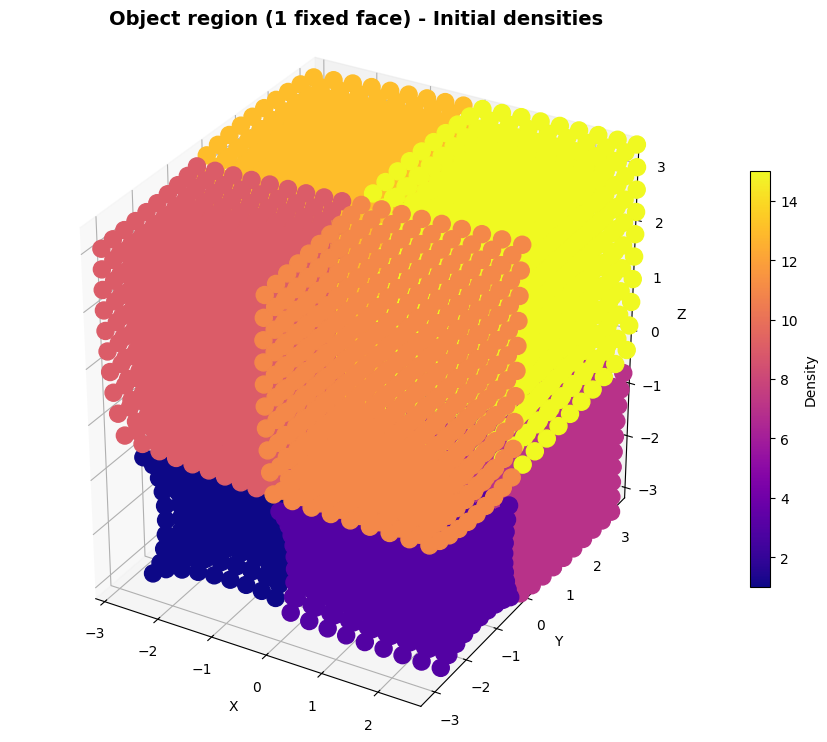

In [40]:
positions_3d_1 = vdgrid1.positions.reshape(vdgrid1.L, vdgrid1.M, vdgrid1.N, 3)

object_densities_1 = rho_0_1[8:26, 7:27, 7:27].ravel()
object_positions_1 = positions_3d_1[8:26, 7:27, 7:27].reshape(object_densities_1.shape[0], 3)

fig = vd.plot_pcd(object_positions_1, object_densities_1,view='3d', point_size=150, alpha=1,title='Object region (1 fixed face) - Initial densities')

### Extra plotting
Visualizing within the larger grid

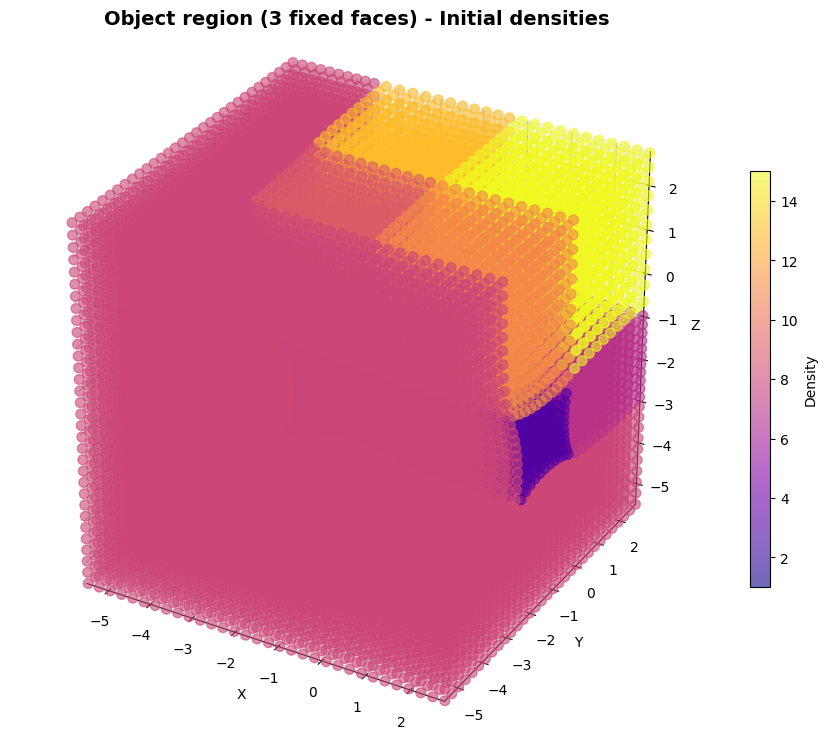

In [92]:
positions_3d_3 = vdgrid3.positions.reshape(vdgrid3.L, vdgrid3.M, vdgrid3.N, 3)

object_densities_3 = rho_0_3.ravel()
object_positions_3 = positions_3d_3.reshape(object_densities_3.shape[0], 3)

fig = vd.plot_pcd(object_positions_3, object_densities_3,view='3d', point_size=50, alpha=0.6,title='Object region (3 fixed faces) - Initial densities')

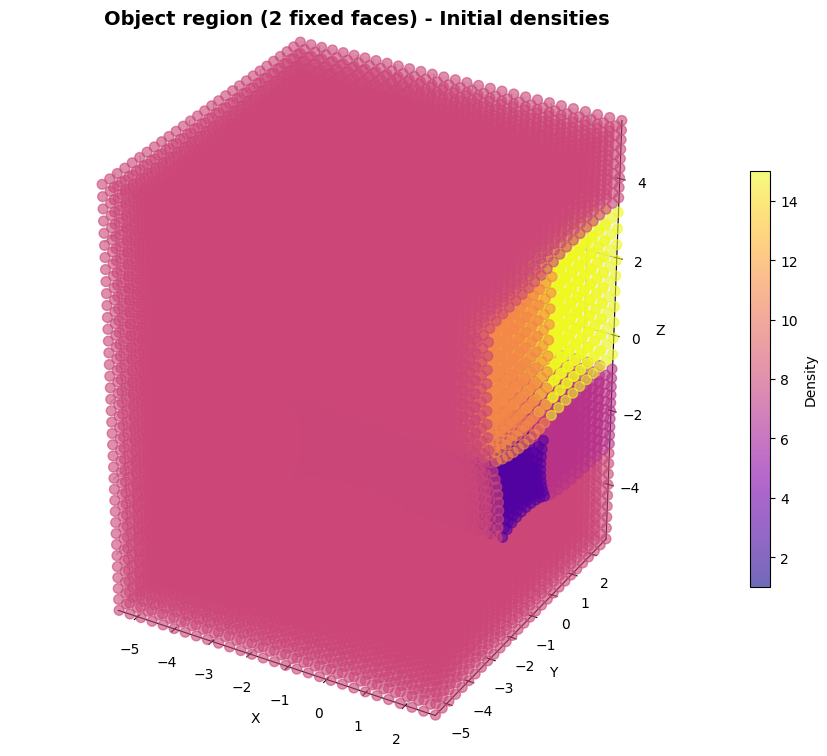

In [93]:
positions_3d_2 = vdgrid2.positions.reshape(vdgrid2.L, vdgrid2.M, vdgrid2.N, 3)

object_densities_2 = rho_0_2.ravel()
object_positions_2 = positions_3d_2.reshape(object_densities_2.shape[0], 3)

fig = vd.plot_pcd(object_positions_2, object_densities_2,view='3d', point_size=50, alpha=0.6,title='Object region (2 fixed faces) - Initial densities')

## Check boundary plane displacement
We observe very small deformations along the boundaries, between 0.1 and 0.5% of the length of the object

In [130]:
def check_boundary_movement(grid, boundary='x_max', 
                           i_range=None, j_range=None, k_range=None):
    """
    Check perpeandicular displacement of boundary nodes.
    
    Only measures movement perpendicular to the boundary plane.
    Can focus on specific index ranges to analyze object region vs sea region.
    
    Parameters
    ----------
    grid : VDERMGrid
        Deformed grid
    boundary : str, default='x_max'
        Which boundary to check: 'x_max', 'x_min', 'y_max', 'y_min', 'z_max', 'z_min'
    i_range : slice or tuple, optional
        Range of i indices to analyze. If None, uses all.
        Example: slice(10, 30) or (10, 30)
    j_range : slice or tuple, optional
        Range of j indices to analyze. If None, uses all.
    k_range : slice or tuple, optional
        Range of k indices to analyze. If None, uses all.
    
    Returns
    -------
    displacement_perp : ndarray
        Perpendicular displacement values for the selected region
    """
    # Reshape to 3D grid
    initial_3d = grid.initial_positions.reshape(grid.L, grid.M, grid.N, 3)
    final_3d = grid.positions.reshape(grid.L, grid.M, grid.N, 3)
    
    # Parse ranges - convert tuples to slices
    def parse_range(r):
        if r is None:
            return slice(None)
        elif isinstance(r, tuple):
            return slice(*r)
        else:
            return r
    
    i_slice = parse_range(i_range)
    j_slice = parse_range(j_range)
    k_slice = parse_range(k_range)
    
    # Extract boundary and compute perpendicular displacement
    if boundary == 'x_max':
        initial_boundary = initial_3d[-1, j_slice, k_slice, :]
        final_boundary = final_3d[-1, j_slice, k_slice, :]
        axis = 0  # X direction
        axis_name = 'X'
        
    elif boundary == 'x_min':
        initial_boundary = initial_3d[0, j_slice, k_slice, :]
        final_boundary = final_3d[0, j_slice, k_slice, :]
        axis = 0
        axis_name = 'X'
        
    elif boundary == 'y_max':
        initial_boundary = initial_3d[i_slice, -1, k_slice, :]
        final_boundary = final_3d[i_slice, -1, k_slice, :]
        axis = 1  # Y direction
        axis_name = 'Y'
        
    elif boundary == 'y_min':
        initial_boundary = initial_3d[i_slice, 0, k_slice, :]
        final_boundary = final_3d[i_slice, 0, k_slice, :]
        axis = 1
        axis_name = 'Y'
        
    elif boundary == 'z_max':
        initial_boundary = initial_3d[i_slice, j_slice, -1, :]
        final_boundary = final_3d[i_slice, j_slice, -1, :]
        axis = 2  # Z direction
        axis_name = 'Z'
        
    elif boundary == 'z_min':
        initial_boundary = initial_3d[i_slice, j_slice, 0, :]
        final_boundary = final_3d[i_slice, j_slice, 0, :]
        axis = 2
        axis_name = 'Z'
        
    else:
        raise ValueError(
            f"boundary must be 'x_max', 'x_min', 'y_max', 'y_min', 'z_max', or 'z_min', "
            f"got '{boundary}'"
        )
    
    # Only perpendicular component
    displacement_perp = (final_boundary - initial_boundary)[..., axis]
    
    # Print statistics
    print(f"\n{boundary} perpendicular movement ({axis_name} direction):")
    print(f"  Region analyzed: {displacement_perp.size} boundary points")
    print(f"  Mean: {np.abs(displacement_perp).mean():.6f}")
    print(f"  Max: {np.abs(displacement_perp).max():.6f}")
    print(f"  Std: {displacement_perp.std():.6f}")
    print(f"  Range: [{displacement_perp.min():.6f}, {displacement_perp.max():.6f}]")
    
    return displacement_perp

# 3 fixed faces - object region, x plane
disp_3fixed_obj = check_boundary_movement(
    vdgrid3, 'x_max',
    j_range=(10, 32), k_range=(10, 32)  # Object region
)
# 3 fixed faces - object region, y plane
disp_3fixed_obj = check_boundary_movement(
    vdgrid3, 'y_max',
    i_range=(10, 32), k_range=(10, 32)  # Object region
)
# 3 fixed faces - object region, z plane
disp_3fixed_obj = check_boundary_movement(
    vdgrid3, 'z_max',
    i_range=(10, 32), j_range=(10, 32)  # Object region
)

# 1 fixed face - object region 
disp_1fixed_obj = check_boundary_movement(
    vdgrid1, 'x_max',
    j_range=(7, 27), k_range=(7, 27)  # Object region
)

# 2 fixed faces - object region, x plane
disp_2fixed_obj = check_boundary_movement(
    vdgrid2, 'x_max',
    j_range=(9, 29), k_range=(9, 29)  # Object region
)

# 2 fixed faces - object region, y plane
disp_2fixed_obj = check_boundary_movement(
    vdgrid2, 'y_max',
    i_range=(9, 29), k_range=(9, 29)  # Object region
)


x_max perpendicular movement (X direction):
  Region analyzed: 484 boundary points
  Mean: 0.006792
  Max: 0.007931
  Std: 0.001186
  Range: [-0.007931, -0.002471]

y_max perpendicular movement (Y direction):
  Region analyzed: 484 boundary points
  Mean: 0.012579
  Max: 0.014904
  Std: 0.001942
  Range: [-0.014904, -0.005490]

z_max perpendicular movement (Z direction):
  Region analyzed: 484 boundary points
  Mean: 0.022458
  Max: 0.025728
  Std: 0.003280
  Range: [-0.025728, -0.010660]

x_max perpendicular movement (X direction):
  Region analyzed: 400 boundary points
  Mean: 0.006871
  Max: 0.009721
  Std: 0.001467
  Range: [-0.009721, -0.003043]

x_max perpendicular movement (X direction):
  Region analyzed: 400 boundary points
  Mean: 0.006383
  Max: 0.008148
  Std: 0.001267
  Range: [-0.008148, -0.002693]

y_max perpendicular movement (Y direction):
  Region analyzed: 400 boundary points
  Mean: 0.012054
  Max: 0.015556
  Std: 0.002410
  Range: [-0.015556, -0.005727]
